Анализ данных и их представление

In [ ]:
!pip install association-metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3928 sha256=938efb151e4e074f0d72bbe148841bb4af823c1c76a49043dbc5f5301139aeb2
  Stored in directory: /root/.cache/pip/wheels/18/bd/17/1d2797e86c263937dab5965950332519bd9dd8bddd746c88bc
Successfully built association-metrics


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import association_metrics as am
from scipy import stats

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme(
    style='whitegrid',
    font_scale=1.2
)
cmap = ListedColormap(['skyblue', 'salmon'])

In [ ]:
plt.rcParams.update({
    "axes.titlesize":   12,
    "axes.titleweight": "bold",
    "axes.labelsize":   10,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "axes.prop_cycle":  plt.cycler("color", ["skyblue"]),
    "figure.constrained_layout.use": True,
})

In [ ]:
data = pd.read_csv('/content/final_data.csv', index_col = 0)
data.head()

,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,FL_PRESENCE_FL,OWN_AUTO,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,WORK_TIME,FAMILY_INCOME,PERSONAL_INCOME,FACT_FO,TARGET
0,49,1,Среднее специальное,Состою в браке,2,1,1,0,0,0,Торговля,Рабочий,Вспомогательный техперсонал,18.0,от 10000 до 20000 руб.,5000.0,ПФО,0
2,32,1,Среднее,Состою в браке,3,3,1,0,0,0,Торговля,Рабочий,Участие в основ. деятельности,97.0,от 10000 до 20000 руб.,12000.0,СКФО,0
3,52,1,Неполное среднее,Состою в браке,4,0,1,0,0,0,Информационные технологии,Специалист,Участие в основ. деятельности,84.0,от 10000 до 20000 руб.,9000.0,СФО,0
4,39,1,Высшее,Состою в браке,1,1,1,0,1,0,Образование,Руководитель среднего звена,Участие в основ. деятельности,168.0,от 20000 до 50000 руб.,25000.0,ЮФО,0
5,30,0,Среднее,Состою в браке,0,0,1,0,0,0,Государственная служба,Специалист,Участие в основ. деятельности,101.0,от 10000 до 20000 руб.,12000.0,СКФО,0


In [ ]:
data = data.drop_duplicates()

In [ ]:
data['DEPENDANTS'].value_counts()

,count
DEPENDANTS,
0,6947
1,4436
2,2132
3,238
4,39
5,5
6,4
7,1


In [ ]:
data['OWN_AUTO'] = data['OWN_AUTO'].apply(lambda x: 1 if x >= 1 else 0)

In [ ]:
data['CHILD_TOTAL'] = data['CHILD_TOTAL'].apply(lambda x: '5 и более' if x >= 5 else x)

In [ ]:
data['DEPENDANTS'] = data['DEPENDANTS'].apply(lambda x: '4 и более' if x >= 4 else x)

In [ ]:
data['DEPENDANTS'].value_counts()

,count
DEPENDANTS,
0,6947
1,4436
2,2132
3,238
4 и более,49


# Общий обзор данных.
Кол-во строк, кол-во признаков. Кол-во числовых и категориальных признаков. Пропущенные значения, дублирующиеся значения.

In [ ]:
overview = {
    'rows':               data.shape[0],
    'features':           data.shape[1],
    'missing values':     data.isnull().sum().sum(),
    'duplicates':         data.duplicated().sum(),
    'numerical features': 3,
    'categorical features': data.shape[1] - 3
}

In [ ]:
overview_df = pd.DataFrame.from_dict(data = overview, orient = 'index', columns = ['Value'])
overview_df.index.name = 'Metric'
overview_df.to_csv('Data_overview.csv')

In [ ]:
overview_df

,Value
Metric,
rows,13802
features,18
missing values,0
duplicates,0
numerical features,3
categorical features,15


В датасете после очистки выбросов и удаления характеристик, которые сильно коррелирование с другими признакми, осталось 13803 объекта и 18 признаков. В датасете остался 1 дупликат. Всего в датасете 3 числовых признака и 15 категориальных, некоторые категориальные признаки уже закодированы: пол, наличие автомобиля и т.д.

# Анализ признаков

In [ ]:
all_features =list(data.columns)

In [ ]:
num_features = ['AGE', 'PERSONAL_INCOME', 'WORK_TIME']
cat_features = [feature for feature in all_features if feature not in num_features]

## Анализ числовых признаков. Зависимость между таргетом и числовыми признаками. Анализ значений

Анализируем 3 признака: возраст, доход и стаж работы в месяцах. Смотрим на распределение данных (boxplot и гистограмму). Далее расчитываем коэффициент корреляции Спирмена между признаками и таргетом и смотрим на связь между ними.

In [ ]:
def plot_deviation(col, data = data):

  fig, ax = plt.subplots(3, 1, figsize = (6, 9))
  sns.boxplot(data[col], ax=ax[0], orient = 'h')
  ax[0].set_title(f'Boxplot for feature: {col}')
  sns.histplot(data[col], ax=ax[1], kde=True)
  ax[1].set_title(f'Histplot for feature: {col}')
  sns.histplot(np.log1p(data[col]), ax=ax[2], kde=True)
  ax[2].set_title(f'Histplot for log of feature {col}')
  plt.show()

In [ ]:
def stats_tests(col, data=data):
  results = {}
  stat, p = stats.normaltest(data[col])
  results['Тест на нормальность'] = "D’Agostino"
  results['p_value нормальности'] = p
  results['Нормальное распределение'] = 'Да' if p > 0.05 else 'Нет'

  if (data[col] > 0).all():
        log_feature_data = np.log1p(data[col])
        log_stat, log_p = stats.normaltest(log_feature_data)
        results['p_value лог-нормальности'] = log_p
        results['Лог-нормальное распределение'] = 'Да' if log_p > 0.05 else 'Нет'
  else:
        log_p = np.nan
        results['p_value лог-нормальности'] = log_p
        results['Лог-нормальное распределение'] = 'Невозможно (<=0)'

  if results['Лог-нормальное распределение'] == 'Да':
        analysis_data = np.log1p(data[col])
  else:
        analysis_data = data[col]

  group0 = analysis_data[data['TARGET'] == 0]
  group1 = analysis_data[data['TARGET'] == 1]

  # 4. Статистический тест
  if p > 0.05:
      test_name = 't-test'
      stat_test, p_stat = stats.ttest_ind(group0, group1, equal_var=False)
  else:
      test_name = 'Mann–Whitney U'
      stat_test, p_stat = stats.mannwhitneyu(group0, group1)

  results['Статистический тест'] = test_name
  results['p_value сравнения групп'] = p_stat

  # 5. Корреляция
  if p > 0.05:
      corr_test = 'Pearson'
      corr_coeff, corr_p = stats.pearsonr(data[col], data['TARGET'])
  else:
      corr_test = 'Spearman'
      corr_coeff, corr_p = stats.spearmanr(data[col], data['TARGET'])

  results['Корреляционный тест'] = corr_test
  results['Коэффициент корреляции'] = corr_coeff
  results['p_value корреляции'] = corr_p

  # 6. Визуализация
  sns.boxplot(x='TARGET', y=col, data=data)
  plt.title(f'Boxplot: {col} по категориям TARGET')
  plt.xlabel('TARGET')
  plt.ylabel(col)
  plt.show()

  # 7. Результат как таблица
  result_df = pd.DataFrame(results, index=[col])
  return result_df




### Признак: AGE

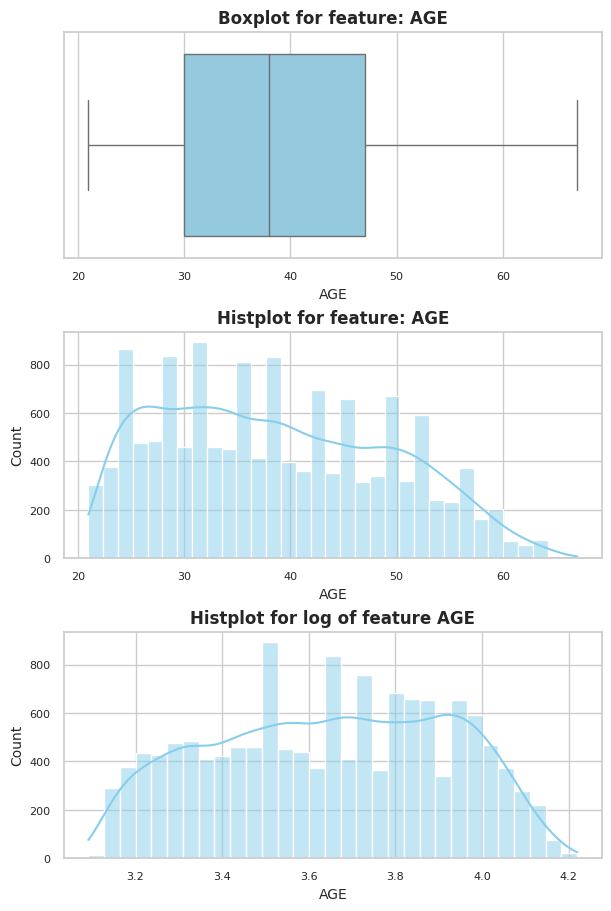

In [ ]:
plot_deviation('AGE')

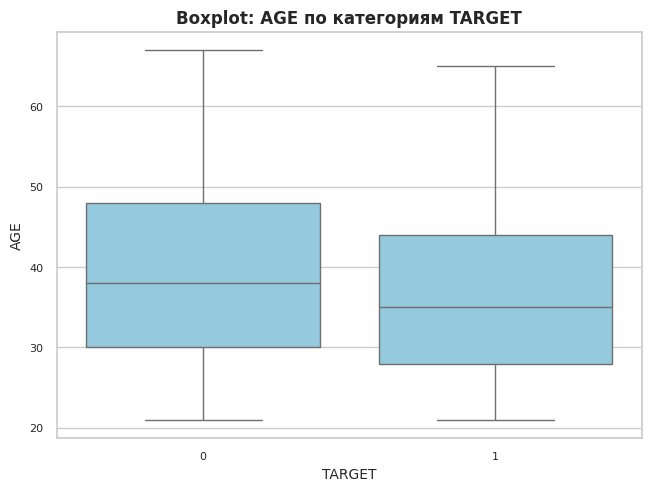

In [ ]:
age_stats_df = stats_tests('AGE')

In [ ]:
age_stats_df

,Тест на нормальность,p_value нормальности,Нормальное распределение,p_value лог-нормальности,Лог-нормальное распределение,Статистический тест,p_value сравнения групп,Корреляционный тест,Коэффициент корреляции,p_value корреляции
AGE,D’Agostino,0.0,Нет,0.0,Нет,Mann–Whitney U,1.584689e-17,Spearman,-0.072531,1.443774e-17


In [ ]:
age_stats_df.to_csv('AGE stats test.csv')

Между возрастом и откликом на рекламную кампанию наблюдается слабая, но статистически значимая отрицательная связь. Это может указывать на тенденцию: молодые пользователи склонны чаще реагировать на предложение, однако сила этой связи невелика (ρ = –0.073), и возраст не является доминирующим фактором.

### Personal Income

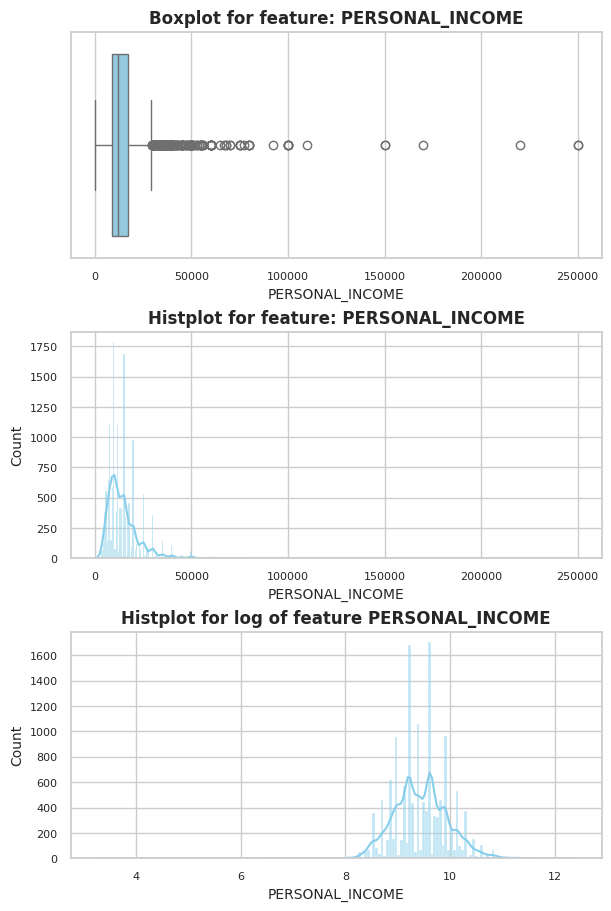

In [ ]:
plot_deviation('PERSONAL_INCOME')

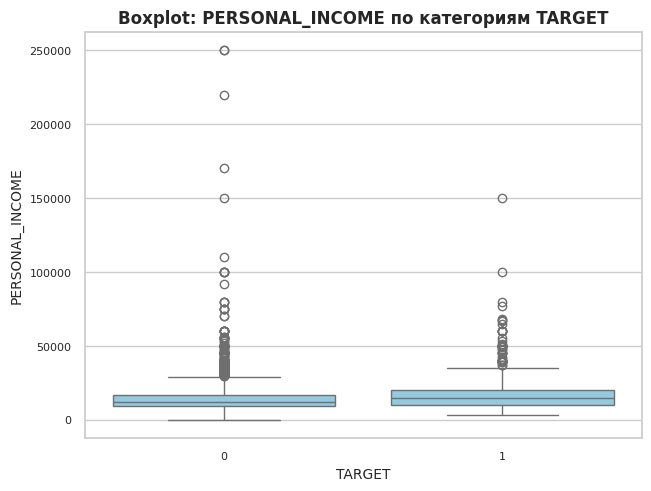

In [ ]:
pi_stats_df = stats_tests('PERSONAL_INCOME')

In [ ]:
pi_stats_df

,Тест на нормальность,p_value нормальности,Нормальное распределение,p_value лог-нормальности,Лог-нормальное распределение,Статистический тест,p_value сравнения групп,Корреляционный тест,Коэффициент корреляции,p_value корреляции
PERSONAL_INCOME,D’Agostino,0.0,Нет,3.286093e-153,Нет,Mann–Whitney U,2.460891e-21,Spearman,0.080725,2.131214e-21


Между таргетом и доходом наблюдается слабая положительная связь. Было доказано, что есть зависимость между доходом и откликом на рекламную кампанию: люди с большим доходом чаще откликаются,однако коэффициент Спирмена довольно мал и составляет 0.0807.

In [ ]:
pi_stats_df.to_csv('PERSONAL_INCOME stats test.csv')

### WORK_TIME

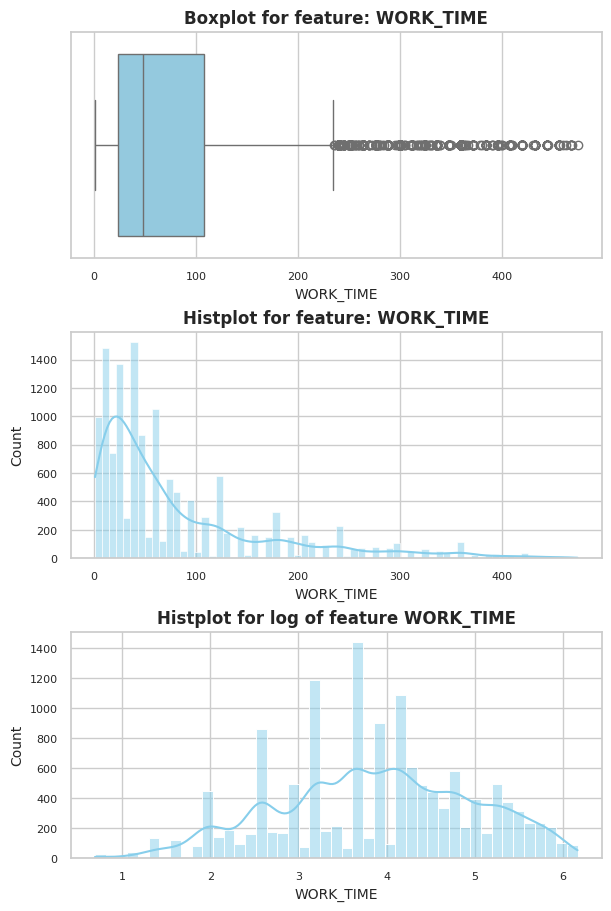

In [ ]:
plot_deviation('WORK_TIME')

У признака наблюдаются выбросы, которые отражаются в гистограмме как тяжелый хвост. При логарифмировании хвост уже меньше.

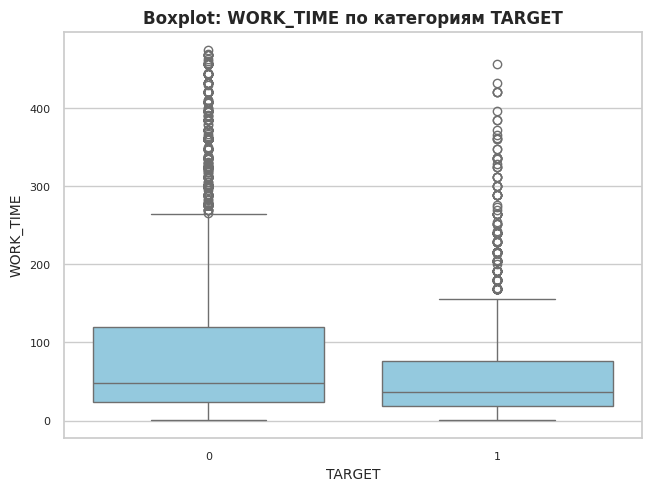

In [ ]:
WT_stats_df = stats_tests('WORK_TIME')

In [ ]:
WT_stats_df

,Тест на нормальность,p_value нормальности,Нормальное распределение,p_value лог-нормальности,Лог-нормальное распределение,Статистический тест,p_value сравнения групп,Корреляционный тест,Коэффициент корреляции,p_value корреляции
WORK_TIME,D’Agostino,0.0,Нет,7.581672e-99,Нет,Mann–Whitney U,3.074260e-22,Spearman,-0.082552,2.626288e-22


Также по признаку стаж работы есть небольшая отрицательная зависимость: люди с меньшим стажом больше реагирует, но связь довольна мала (-0.0825).

In [ ]:
WT_stats_df.to_csv('WORK_TIME stats test.csv')

In [ ]:
num_stats_df = pd.concat([age_stats_df, pi_stats_df, WT_stats_df])

In [ ]:
num_stats_df.to_csv('NUM features stat test.csv')

## Корреляция между числовыми признаками. Вывод

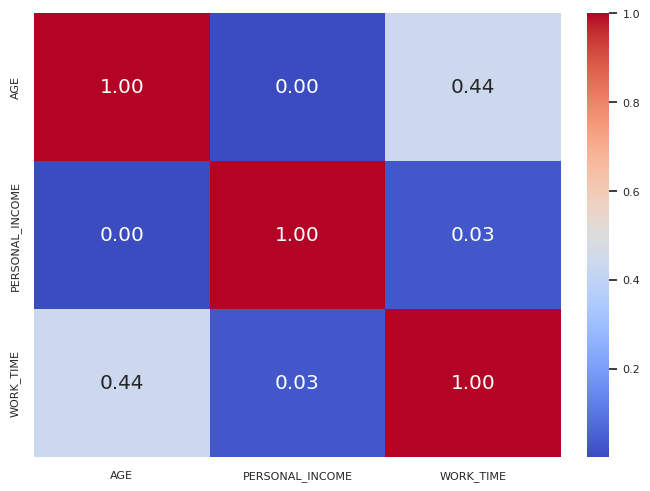

In [ ]:
corr = data[num_features].corr()
#custom_cmap = LinearSegmentedColormap.from_list('custom', ['skyblue', 'salmon'])
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

Есть умеренная зависимость между возрастом и стажем, что вцелом логично: чем старше человек - тем больше у него стаж. В остальном признаки не коррелируют между собой.

## Вывод по анализу числовых признаков:
1. Между значениями числовых признаков в различных категориях таргета наблюдаются статистически значимые различия. Это подтверждено с помощью критерия Манна–Уитни, а также оценки корреляционной зависимости с использованием коэффициента Спирмена.

2. Связь между числовыми признаками и таргетной переменной является слабой, но статистически значимой. У признака PERSONAL_INCOME выявлена слабая прямая корреляция с таргетом, а у признаков AGE и WORK_TIME — слабая обратная связь.

3. Между числовыми признаками наблюдается низкий уровень взаимной корреляции, за исключением пары AGE и WORK_TIME, для которой выявлена умеренная положительная связь. Однако наличие прямой зависимости не установлено, поэтому оба признака могут быть сохранены в дальнейшей работе.

## Анализ категориальных признаков. Зависимость между таргетом и признаками.

In [ ]:
def plot_cat_barplots(col, data=data):

  fig, axes = plt.subplots(3, 1, figsize = (6, 10))

  order = data[col].value_counts().index.to_list()
  sns.countplot(data=data, x = col, hue = 'TARGET', order=order, ax = axes[0], palette = ['skyblue', 'salmon'])
  axes[0].set_title(f'Кол-во положительных и негативных откликов в группах {col}', fontsize=11)
  axes[0].set_ylabel('Count')
  axes[0].set_xlabel('')
  axes[0].tick_params(axis='x', labelsize=8, labelbottom=False)


  for c in axes[0].containers:
      axes[0].bar_label(c, fmt='%d', padding=2, fontsize=8)

  axes[0].legend(
      title='TARGET',
      loc='upper right',
      fontsize=8,
      title_fontsize=10
  )

  df_rate = data.groupby(col)['TARGET'].mean().mul(100).reset_index(name = 'response_rate')
  sns.barplot(data = df_rate, x=col, y='response_rate', order=order, color='skyblue', ax=axes[1])
  axes[1].set_title(f'Доля положительного отклика по группам {col}', fontsize=11)
  axes[1].set_ylabel('Count')
  axes[1].set_xlabel('')
  axes[1].tick_params(axis='x', labelsize=8, labelbottom=False)
  for c in axes[1].containers:
      axes[1].bar_label(c, fmt='%.1f%%', fontsize=8)

  df_share = data.loc[data['TARGET']==1, col].value_counts(normalize=True).mul(100).reset_index(name = 'share')
  sns.barplot(
        data=df_share,
        x=col, y='share',
        order=order,
        color='salmon',
        ax=axes[2]
    )
  axes[2].set_title(f'Вклад категории {col} в положительный отклик', fontsize=11)
  axes[2].set_ylabel('Count')
  axes[2].tick_params(axis='x', labelsize=8, labelbottom=True, rotation=90)
  for c in axes[2].containers:
      axes[2].bar_label(c, fmt='%.1f%%', fontsize=8)


In [ ]:
def cramers_v(x, y):
    cont = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(cont, correction=False)[0]
    n = cont.values.sum()
    phi2 = chi2 / n
    r, k = cont.shape
    return np.sqrt(phi2 / min(r-1, k-1))

In [ ]:
def stat_tests_cat(col, data=data):
    result = {}

    # Таблица сопряжённости
    contingency_table = pd.crosstab(data[col], data['TARGET'])

    # Выбор теста
    if contingency_table.shape == (2, 2):
        stat, p_value = stats.fisher_exact(contingency_table)
        test_type = "Fisher's Exact Test"
    else:
        stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_type = "Chi-Square Test"

    # Коэффициент связи
    v = cramers_v(data[col], data['TARGET'])

    # Результаты
    result['Признак'] = col
    result['Тип теста'] = test_type
    result['p_value'] = round(p_value, 5)
    result["Наличие статистической связи"] = 'Да' if p_value < 0.05 else 'Нет'
    result["Коэффициент Cramér's V"] = round(v, 4)

    return result


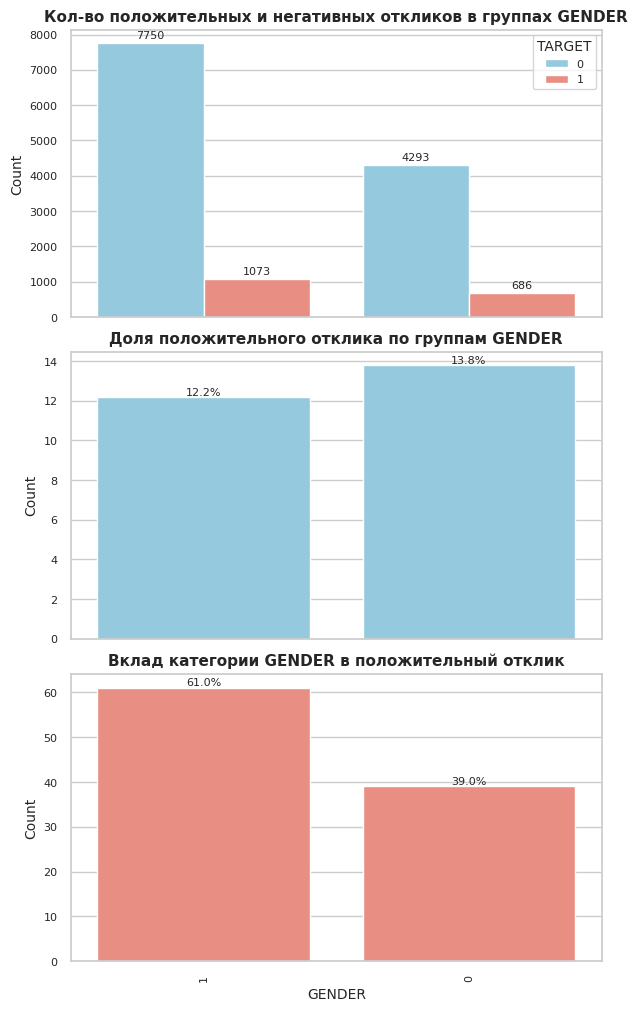

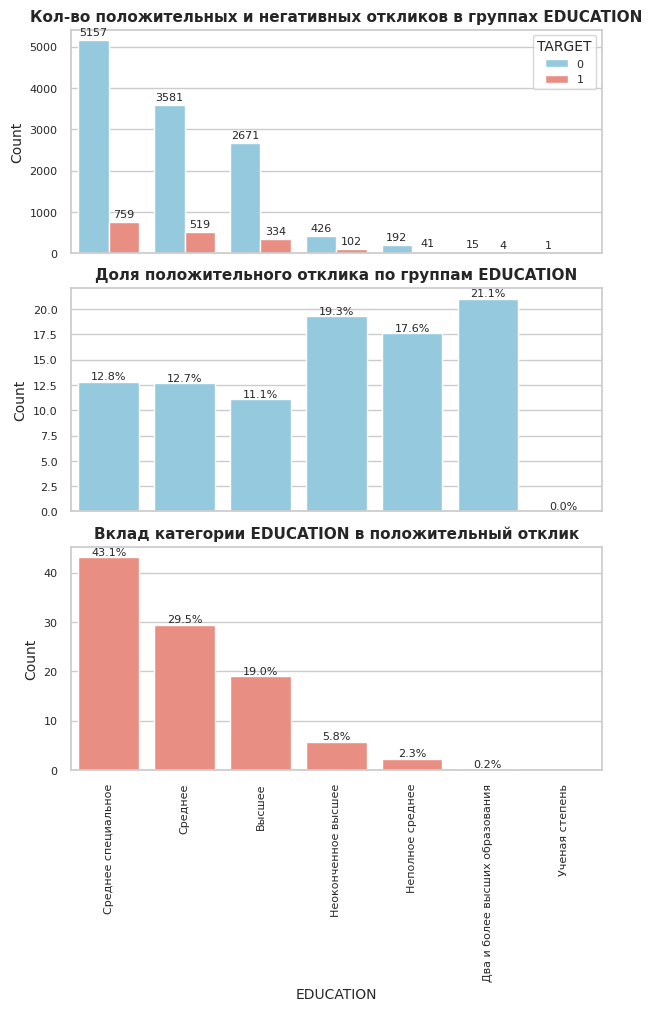

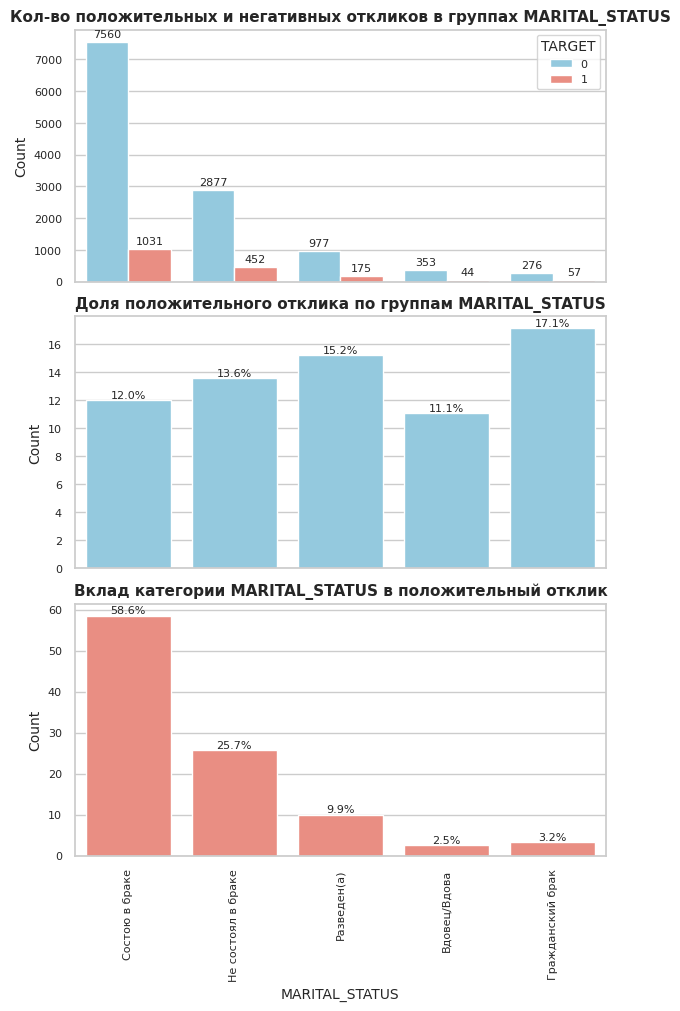

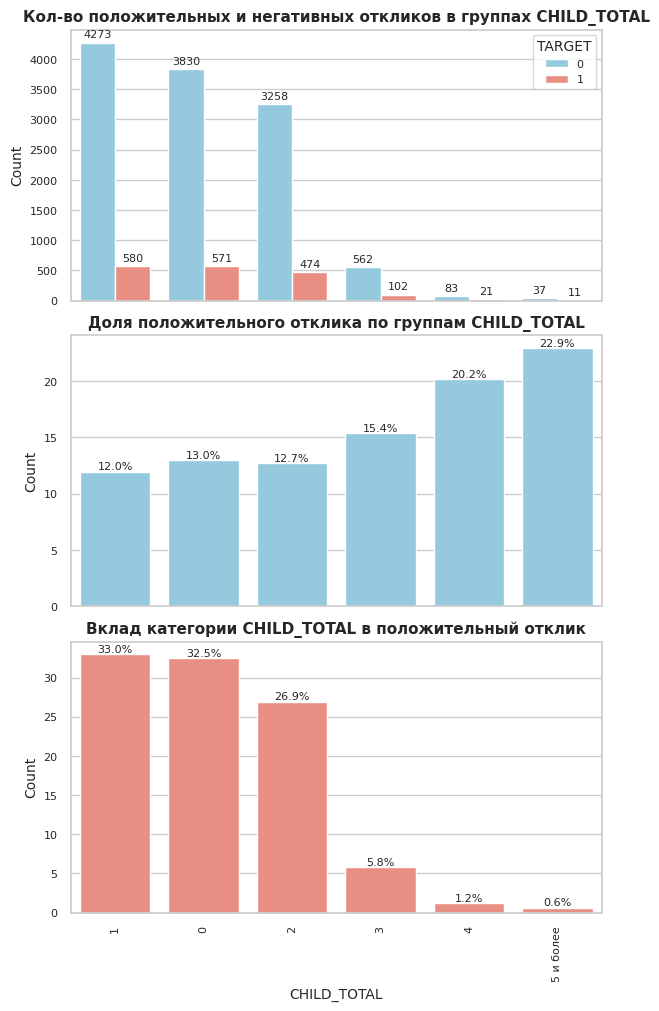

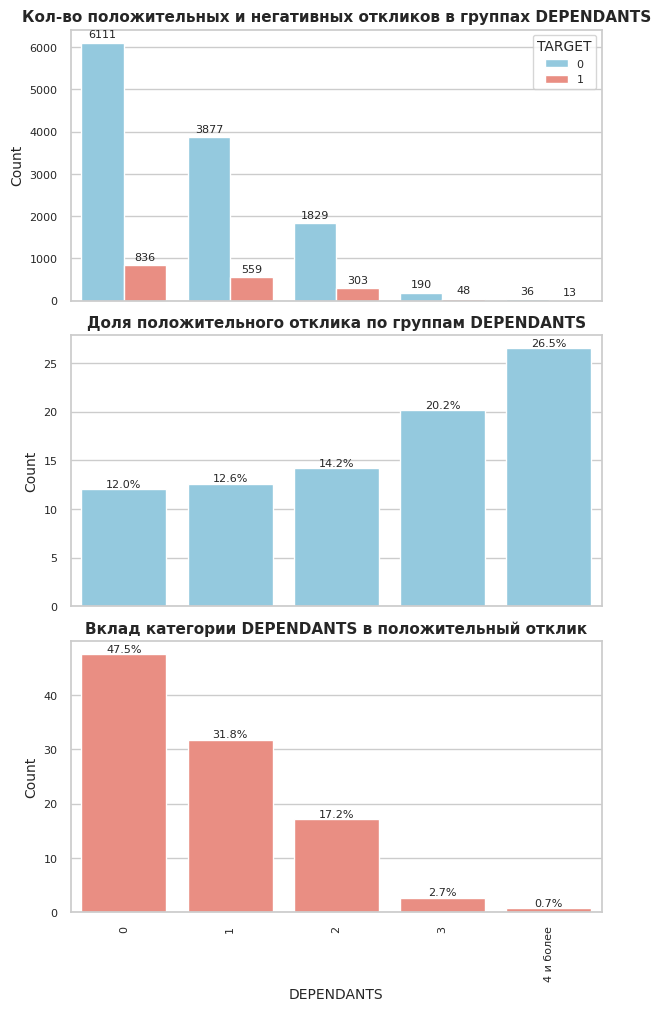

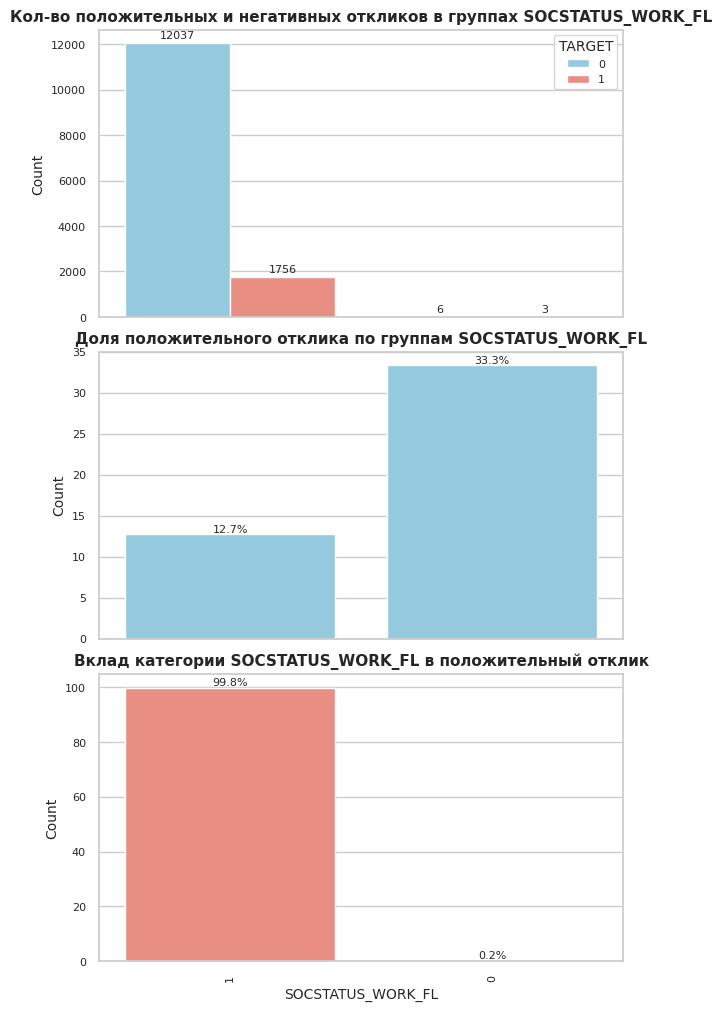

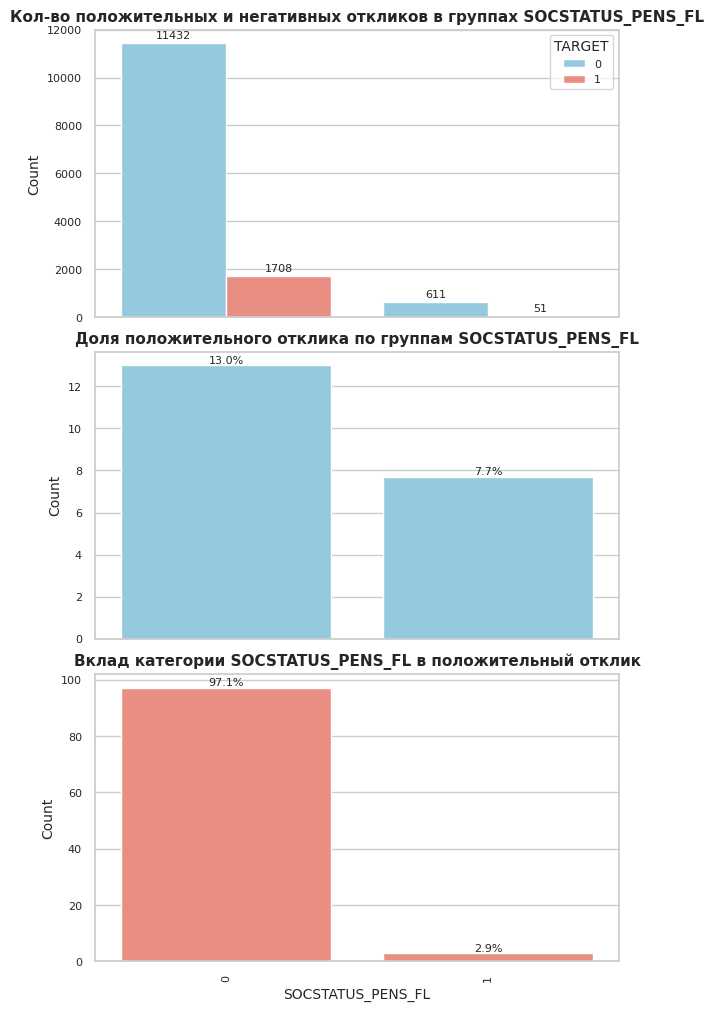

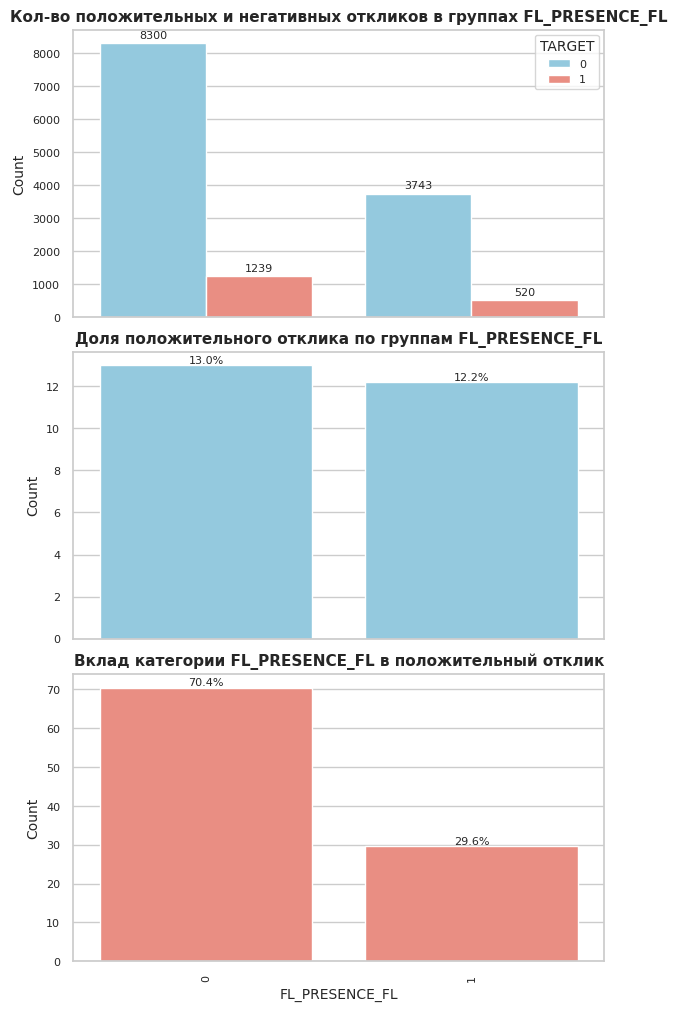

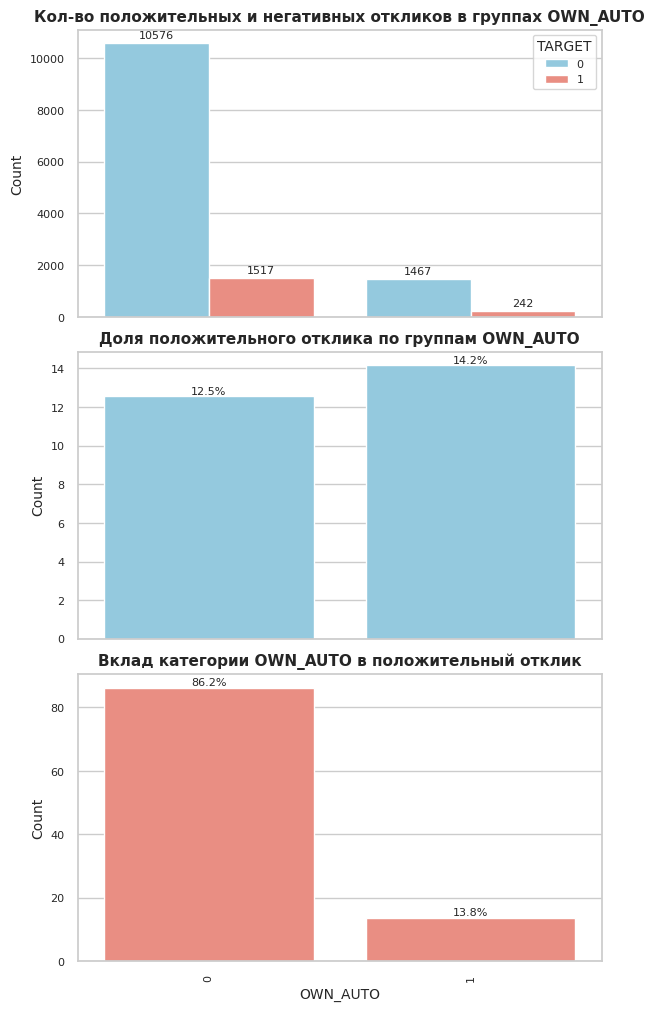

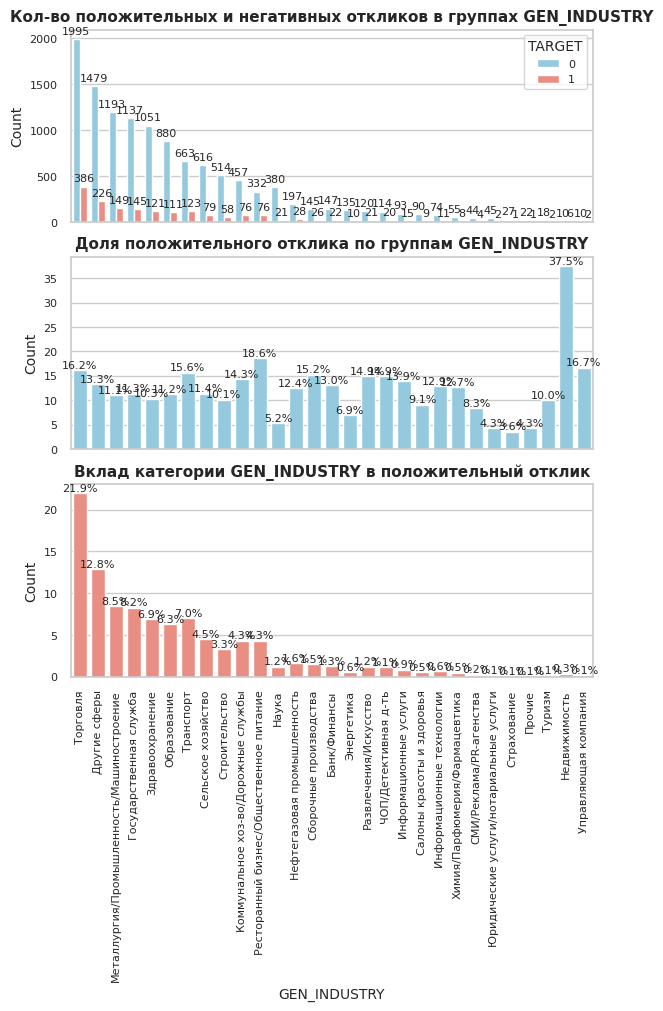

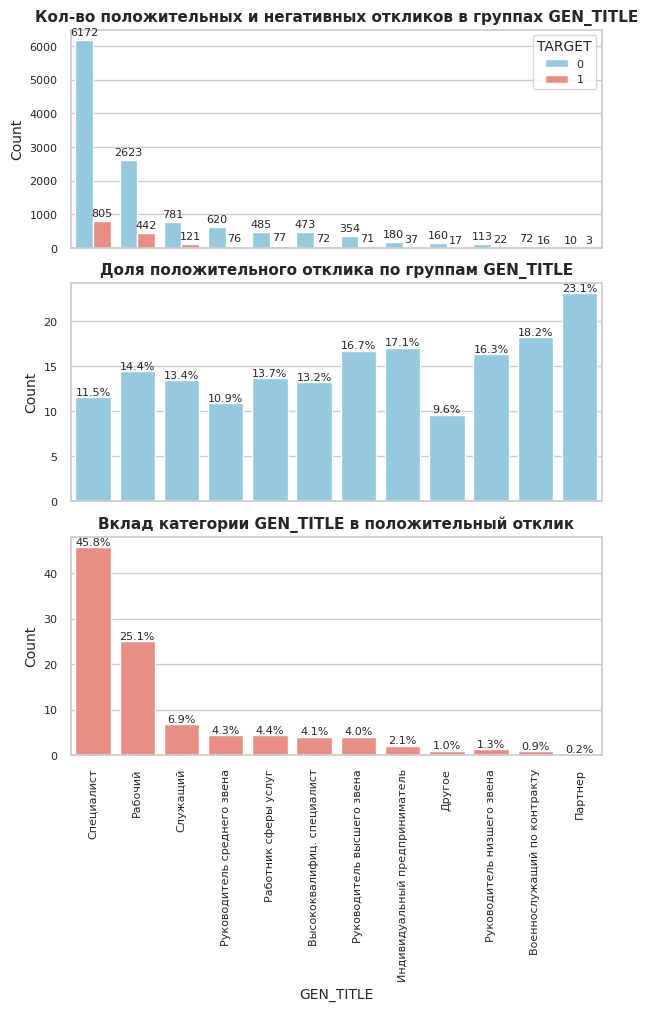

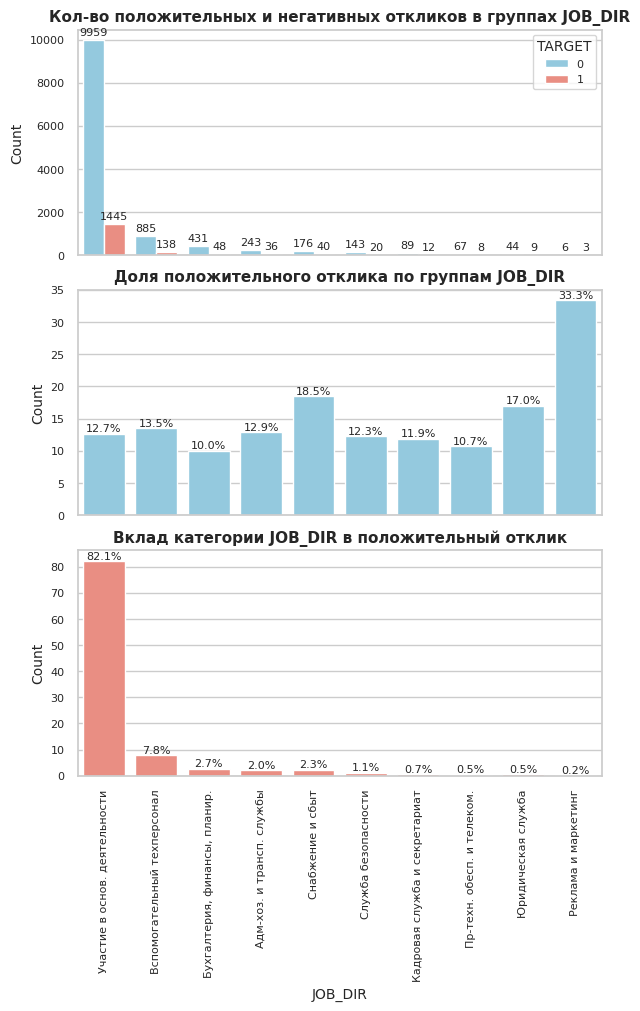

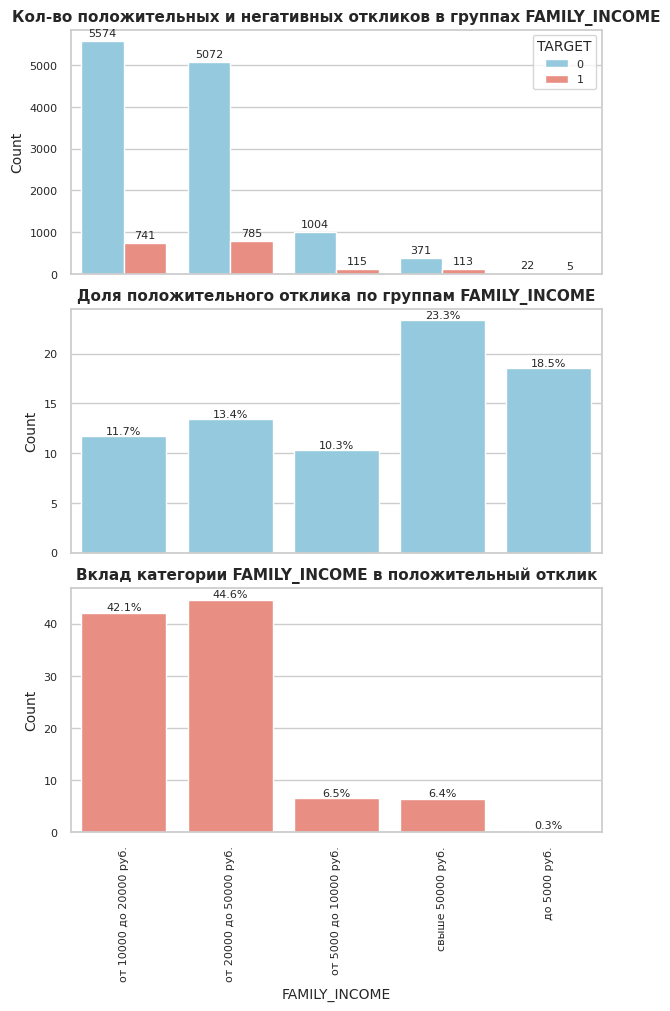

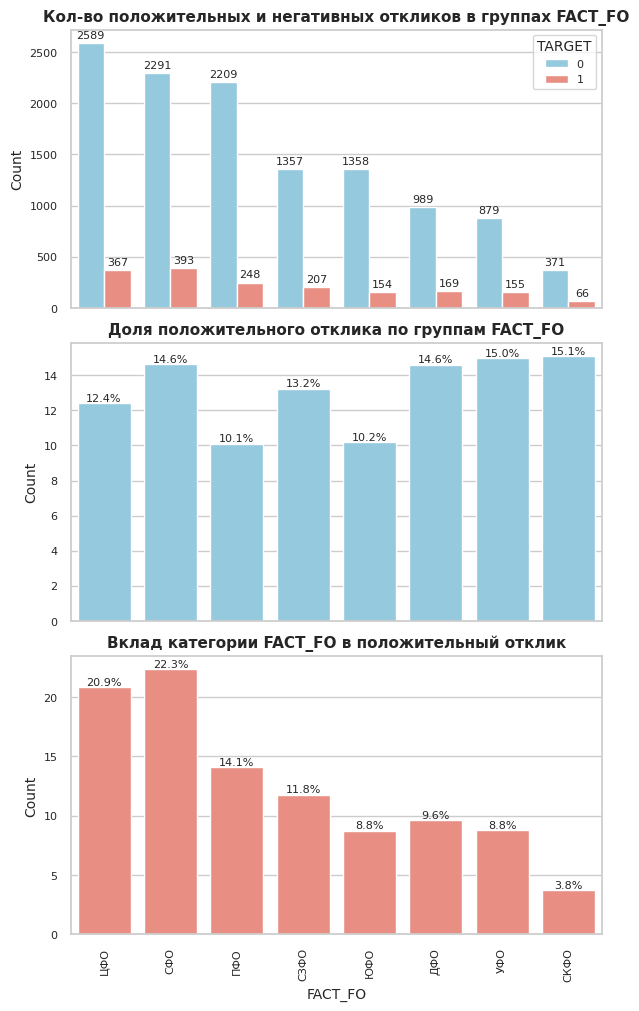

In [ ]:
for feature in cat_features[:-1]:
  plot_cat_barplots(feature)

In [ ]:
results = []
for col in cat_features[:-1]:
  results.append(stat_tests_cat(col))

In [ ]:
results

[{'Признак': 'GENDER',
  'Тип теста': "Fisher's Exact Test",
  'p_value': np.float64(0.0067),
  'Наличие статистической связи': 'Да',
  "Коэффициент Cramér's V": np.float64(0.0233)},
 {'Признак': 'EDUCATION',
  'Тип теста': 'Chi-Square Test',
  'p_value': np.float64(1e-05),
  'Наличие статистической связи': 'Да',
  "Коэффициент Cramér's V": np.float64(0.0496)},
 {'Признак': 'MARITAL_STATUS',
  'Тип теста': 'Chi-Square Test',
  'p_value': np.float64(0.0007),
  'Наличие статистической связи': 'Да',
  "Коэффициент Cramér's V": np.float64(0.0374)},
 {'Признак': 'CHILD_TOTAL',
  'Тип теста': 'Chi-Square Test',
  'p_value': np.float64(0.0051),
  'Наличие статистической связи': 'Да',
  "Коэффициент Cramér's V": np.float64(0.0348)},
 {'Признак': 'DEPENDANTS',
  'Тип теста': 'Chi-Square Test',
  'p_value': np.float64(2e-05),
  'Наличие статистической связи': 'Да',
  "Коэффициент Cramér's V": np.float64(0.0447)},
 {'Признак': 'SOCSTATUS_WORK_FL',
  'Тип теста': "Fisher's Exact Test",
  'p_value'

In [ ]:
CAT_stat_tests_results = pd.DataFrame(results)

In [ ]:
CAT_stat_tests_results.to_csv('CAT features stats test.csv')

In [ ]:
CAT_stat_tests_results

,Признак,Тип теста,p_value,Наличие статистической связи,Коэффициент Cramér's V
0,GENDER,Fisher's Exact Test,0.00670,Да,0.0233
1,EDUCATION,Chi-Square Test,0.00001,Да,0.0496
2,MARITAL_STATUS,Chi-Square Test,0.00070,Да,0.0374
3,CHILD_TOTAL,Chi-Square Test,0.00510,Да,0.0348
4,DEPENDANTS,Chi-Square Test,0.00002,Да,0.0447
5,SOCSTATUS_WORK_FL,Fisher's Exact Test,0.09620,Нет,0.0158
6,SOCSTATUS_PENS_FL,Fisher's Exact Test,0.00003,Да,0.0339
7,FL_PRESENCE_FL,Fisher's Exact Test,0.20387,Нет,0.0110
8,OWN_AUTO,Fisher's Exact Test,0.06289,Нет,0.0160
9,GEN_INDUSTRY,Chi-Square Test,0.00000,Да,0.0890


In [ ]:
XC = data[cat_features].astype('category')
cramersv = am.CramersV(XC)

cramersv.fit()

,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,FL_PRESENCE_FL,OWN_AUTO,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,FAMILY_INCOME,FACT_FO,TARGET
GENDER,1.000000,0.069189,0.182026,0.056318,0.068289,0.007368,0.086006,0.085836,0.266357,0.408217,0.122632,0.180645,0.119222,0.029117,0.023278
EDUCATION,0.069189,1.000000,0.063609,0.092700,0.039332,0.044609,0.062714,0.057106,0.066038,0.125725,0.146199,0.091026,0.110264,0.047039,0.049647
MARITAL_STATUS,0.182026,0.063609,1.000000,0.205319,0.163041,0.020459,0.151442,0.064349,0.100489,0.074107,0.049043,0.032784,0.130977,0.046748,0.037356
CHILD_TOTAL,0.056318,0.092700,0.205319,1.000000,0.591672,0.023740,0.107092,0.052627,0.023060,0.077310,0.042977,0.031255,0.032005,0.076548,0.034789
DEPENDANTS,0.068289,0.039332,0.163041,0.591672,1.000000,0.019921,0.175104,0.059857,0.058391,0.057531,0.041254,0.031747,0.032275,0.039198,0.044664
SOCSTATUS_WORK_FL,0.007368,0.044609,0.020459,0.023740,0.019921,1.000000,0.113805,0.007496,0.007631,0.037175,0.024256,0.021181,0.064616,0.017216,0.015771
SOCSTATUS_PENS_FL,0.086006,0.062714,0.151442,0.107092,0.175104,0.113805,1.000000,0.069370,0.033939,0.089387,0.039847,0.065563,0.010796,0.078751,0.033928
FL_PRESENCE_FL,0.085836,0.057106,0.064349,0.052627,0.059857,0.007496,0.069370,1.000000,0.041828,0.114852,0.094081,0.036407,0.106982,0.123556,0.010957
OWN_AUTO,0.266357,0.066038,0.100489,0.023060,0.058391,0.007631,0.033939,0.041828,1.000000,0.128814,0.114894,0.083302,0.149417,0.063409,0.015961
GEN_INDUSTRY,0.408217,0.125725,0.074107,0.077310,0.057531,0.037175,0.089387,0.114852,0.128814,1.000000,0.134207,0.129120,0.113994,0.095120,0.088989


## Выводы по анализу категориальных признаков
1. Все категориальные признаки, представленные в наших данных можно разделить на несколько категорий: бинарные признаки (пол, статус работы, статус пенсионера, наличие квартиры), порядковые (образование, кол-во машин, кол-во детей, кол-во иждивенцев, доход в семье) и категориальные (регион, профессия, сфера деятельности и тд.)
2. Не все категориальные признаки демонстрируют статистически значимую связь с таргетной переменной (откликом на рекламную кампанию). Для части признаков различия между категориями не объясняются таргетом, что может говорить об их низкой информативности. Такие признаки потенциально можно исключить на этапе построения модели, чтобы снизить шум и переобучение.
3. Сила связи (Cramér's V).
Для большинства категориальных признаков сила связи с таргетом оказалась слабой (Cramér's V < 0.1).
Наиболее выраженное влияние зафиксировано у признака "сфера деятельности" (GEN_INDUSTRY) — Cramér’s V ≈ 0.08, что всё ещё считается слабой, но наибольшей связью среди категориальных переменных.
4. Сами признаки слабо коррелируют между собой.

# Конечный анализ признаков

In [ ]:
df_num = num_stats_df[['Коэффициент корреляции']].copy()
df_num.columns = ['Сила связи']
df_cat = CAT_stat_tests_results[['Признак', "Коэффициент Cramér's V"]].copy()
df_cat.set_index('Признак', inplace=True)
df_cat.columns = ['Сила связи']
final_df = pd.concat([df_num, df_cat])
final_df = final_df.sort_values('Сила связи', ascending=False)

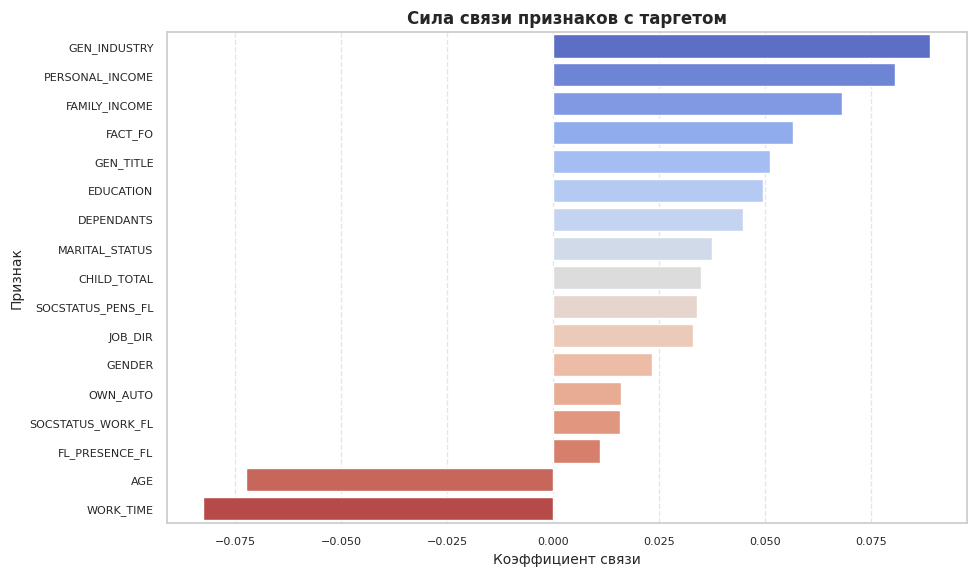

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=final_df.reset_index(),
    x='Сила связи',
    y='index',
    palette='coolwarm'
)
plt.title('Сила связи признаков с таргетом')
plt.xlabel('Коэффициент связи')
plt.ylabel('Признак')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()